[20220922]

# 2. Model 1

After Preparation ready. Build and train the model in here. its using LSTM one layer. with data gen1

## Goal
Find patterns on the features for target

## Plan
Checklist what will be done on the notebook :

        [ ] Get Data
        [ ] Modelling
        [ ] Evaluation

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
from statsmodels.tsa.arima.model import ARIMA
import sys
sys.path.insert(1,'../../src/')

## import myfunc inside src folder
from ramal import eval_model, jampi

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model

from sklearn.model_selection import train_test_split

2022-09-25 01:57:44.563954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-25 01:57:44.564018: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
# PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_MODEL = config['path']['artifact']+'iteration_3'+'/'
PATH_UDF = config['path']['udf']

## Get Data

In [4]:
Xt, yt, Xo, yo = joblib.load(PATH_INTERIM+'feat_target_gen1_iter3.pkl')
Xt = Xt.astype("float32")
yt = yt.astype("float32")

Xo = Xo.astype("float32")
yo = yo.astype("float32")

In [5]:
Xt.shape

(443023, 5, 1)

In [6]:
yt.shape

(443023, 1)

In [7]:
SEQ = Xt.shape[1]

In [8]:
## not the best way to split time series dataset
x_tr, x_test, y_tr, y_test = train_test_split(
    Xt, yt, test_size=0.25, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_tr, y_tr, test_size=0.2, random_state=42)

In [9]:
Xo.shape,yo.shape

((16655, 5, 1), (16655, 1))

## Model 1

In [10]:
# os.environ["CUDA_VISIBLE_DEVICES"] 

In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-09-25 01:57:53.625241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-25 01:57:53.625288: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-25 01:57:53.625304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (62cd00eaf0b9): /proc/driver/nvidia/version does not exist


In [12]:
mod_ts = Sequential()
# mod_ts.add(LSTM(5, input_shape=(SEQ, 1)))
mod_ts.add(LSTM(128, input_shape=(SEQ, 1), return_sequences=True))
mod_ts.add(LSTM(64))
# mod_ts.add(LSTM(8))
mod_ts.add(Dense(32))
mod_ts.add(Dense(16))
mod_ts.add(Dense(1))


2022-09-25 01:57:54.145280: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=6) 

check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'ws_data_model1_iter3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.00065)

mod_ts.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [14]:
history = mod_ts.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
    callbacks=[early_stop,check_p]
)

Epoch 1/50
2077/2077 [==============================] - 53s 24ms/step - loss: 0.6656 - the_rmse: 0.8158 - the_mape: 80799.2891 - val_loss: 0.6489 - val_the_rmse: 0.8055 - val_the_mape: 111996.8438
Epoch 2/50
2077/2077 [==============================] - 50s 24ms/step - loss: 0.6331 - the_rmse: 0.7957 - the_mape: 60686.6406 - val_loss: 0.6355 - val_the_rmse: 0.7972 - val_the_mape: 69996.7891
Epoch 3/50
2077/2077 [==============================] - 49s 24ms/step - loss: 0.6231 - the_rmse: 0.7894 - the_mape: 45113.7070 - val_loss: 0.6224 - val_the_rmse: 0.7889 - val_the_mape: 50092.8516
Epoch 4/50
2077/2077 [==============================] - 52s 25ms/step - loss: 0.6189 - the_rmse: 0.7867 - the_mape: 42411.9492 - val_loss: 0.6271 - val_the_rmse: 0.7919 - val_the_mape: 29261.3516
Epoch 5/50
2077/2077 [==============================] - 52s 25ms/step - loss: 0.6168 - the_rmse: 0.7854 - the_mape: 40950.5430 - val_loss: 0.6192 - val_the_rmse: 0.7869 - val_the_mape: 39209.3867
Epoch 6/50
2077/207

## Eval

<AxesSubplot:>

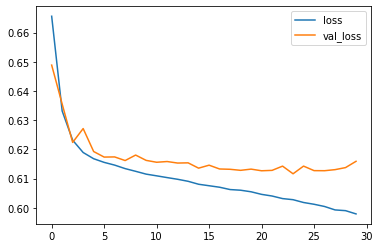

In [15]:
df_epoch_hist = pd.DataFrame(history.history)
df_epoch_hist[['loss','val_loss']].plot()

In [16]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'ws_data_model1_iter3.h5',compile=False)

In [17]:
model_load.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 118,593
Trainable params: 118,593
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_load.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [19]:
model_load.evaluate(x_test,y_test)

3462/3462 [==============================] - 16s 4ms/step - loss: 0.6215 - the_rmse: 0.7884 - the_mape: 48142.4609


[0.6215485334396362, 0.7883834838867188, 48142.4609375]

In [20]:
model_load.evaluate(Xo,yo)

521/521 [==============================] - 2s 4ms/step - loss: 0.4727 - the_rmse: 0.6875 - the_mape: 91012.2812


[0.47270262241363525, 0.6875337362289429, 91012.28125]